### Alternate Approach: Model using SpaCy
Instead of using numerical values in the model, SpaCy uses pure NLP and word frequency to categorized documents. My worry with this method is that the "use" category is very broad so accuracy may not be as good as the initial model.

In [1]:
import pandas as pd
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import string
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import os

from NLP_LLIS_files.lesson_selection_functions import *

datasheet_path = os.path.join(os.getcwd(),'LLIS datasheets','')
#from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, RocCurveDisplay, roc_curve, auc
from sklearn import metrics
import string
import re
import spacy
nlp=spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

In [3]:
topic_stopwords =   ["ames","armstrong","glenn","goddard","katherine","johnson",
                    "jpl","kennedy","langley","marshall","michoud","nasa","plum",
                    "brook","stennis","wallops","white","sands","sand","sandusky",
                    "ohio","cleveland","fairmont","west","virginia","greenbelt",
                    "maryland","virginia","washington","hampton","florida",
                    "huntsville","alabama","mississippi","orleans","louisiana",
                    "houston","texas","las","cruces","mexico","dryden","edwards",
                    "california","pasadena","moffett","field","york","albuquerque",
                    "robert","moscow","sofia", "january", "february", "march", 
                    "april", "may","june", "july", "august", "september", "october", 
                    "november", "december", "csoc", "gsfc", "cofr", "keyword",
                    "germany", "russia", "inch", "meter", "usml", "morning",
                    "also", "lesson", "learn", "lockheed", "martin", "northrop", "grumman",
                    "determine", "pick", "canoga", "park", "william", "think", "please",
                    "refer", "totally", "month", "day", "year", "vandenberg", "senior",
                    "msfc","cause"]
STOPLIST = set(stopwords.words('english') + topic_stopwords)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

In [4]:
train_df = preprocessing(datasheet_path+"train_set_expanded_H.csv")
#encode(train_df)

In [5]:
train_df

,Lesson ID,use,text
0,28105,use,high oxidizer vapor content may cause vapor r...
1,25503,use,highly configurable software architecture all...
2,24403,use,bird-strike hazard outside of landing takeoff...
3,23701,use,robot li-ion battery fire a non-flight robot ...
4,23201,use,rapidscat power subsystem failure the failure...
...,...,...,...
294,389,use,in-flight power converter failure during a sw...
295,308,use,solder balls in flight modules because a desi...
296,378,use,untestable system mode in flight an essential...
297,374,use,higher data rates possible through station ar...


In [6]:
from sklearn.model_selection import train_test_split
X = train_df['text']
y = train_df['use']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
df_validation = preprocessing(datasheet_path+"validation_set_final_H.csv")
X_valid = df_validation['text']
y_valid = df_validation['use']
df_validation['use'].unique()

array(['use', 'not use'], dtype=object)

## Data Exploration

In [8]:
display(train_df)

,Lesson ID,use,text
0,28105,use,high oxidizer vapor content may cause vapor r...
1,25503,use,highly configurable software architecture all...
2,24403,use,bird-strike hazard outside of landing takeoff...
3,23701,use,robot li-ion battery fire a non-flight robot ...
4,23201,use,rapidscat power subsystem failure the failure...
...,...,...,...
294,389,use,in-flight power converter failure during a sw...
295,308,use,solder balls in flight modules because a desi...
296,378,use,untestable system mode in flight an essential...
297,374,use,higher data rates possible through station ar...


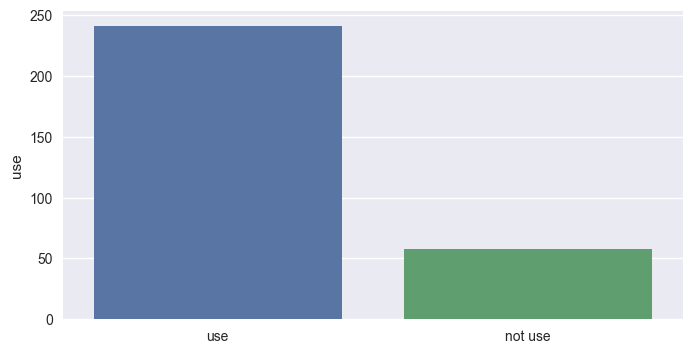

In [9]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,4))
sns.barplot(x = train_df['use'].unique(), y=train_df['use'].value_counts())
plt.show()

In [10]:
train_df['use'].value_counts()

use        241
not use     58
Name: use, dtype: int64

In [11]:
### weights not use heavier
#print(len(train_df))
#new_vals = []
#for i in range (0,2):
#    for n in range (0, len(train_df)):
#        if train_df.iloc[n]['use'] == 'not use':
#            vals = [train_df.iloc[n]['Lesson ID'],train_df.iloc[n]['use'],train_df.iloc[n]['text']]
#            new_vals.append(vals)
#index = len(train_df)
#for i in range(0, len(new_vals)):
#    train_df.loc[int(index)+int(i)]=new_vals[i]
#print(len(train_df))
#train_df['use'].value_counts()

In [12]:
#plt.style.use('seaborn')
#fig = plt.figure(figsize=(8,4))
#sns.barplot(x = train_df['use'].unique(), y=train_df['use'].value_counts())
#plt.show()

In [13]:
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-'and tok.pos_ not in {'PUNCT', 'NUM', 'SYM'}]
        tokens = [tok for tok in tokens if tok not in STOPLIST and tok not in punctuations ]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [14]:
train=train_df

In [15]:
Use_text = [text for text in train[train['use'] == 'use']['text']]

Not_Use_text = [text for text in train[train['use'] == 'not use']['text']]

use_clean = cleanup_text(Use_text)
use_clean = ' '.join(use_clean).split()

not_use_clean = cleanup_text(Not_Use_text)
not_use_clean = ' '.join(not_use_clean).split()

use_counts = Counter(use_clean)
not_use_counts = Counter(not_use_clean)

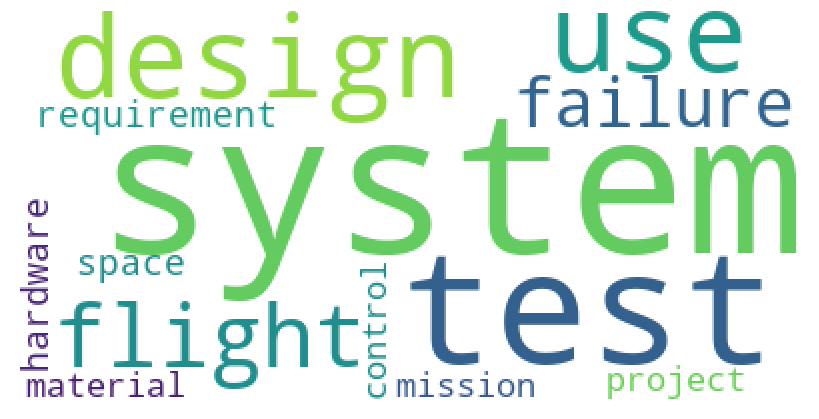

In [16]:
from wordcloud import WordCloud
#print(type(use_common_words))
use_common_words = [word[0] for word in use_counts.most_common(30)]
use_common_counts = [word[1] for word in use_counts.most_common(30)]

wordcloud = WordCloud(background_color ='white', min_font_size = 10).generate(' '.join(use_common_words))

# Display the generated image:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

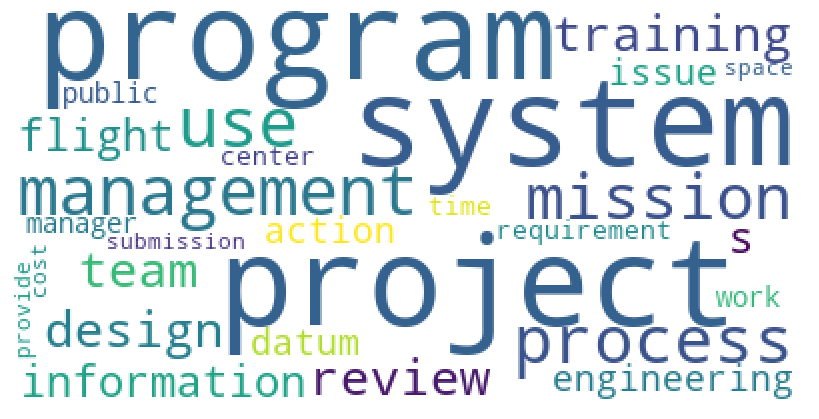

In [17]:
not_use_common_words = [word[0] for word in not_use_counts.most_common(30) if word not in use_common_words]
not_use_common_counts = [word[1] for word in not_use_counts.most_common(30) if word not in use_common_words]
wordcloud = WordCloud(background_color ='white', min_font_size = 10).generate(' '.join(not_use_common_words))

# Display the generated image:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

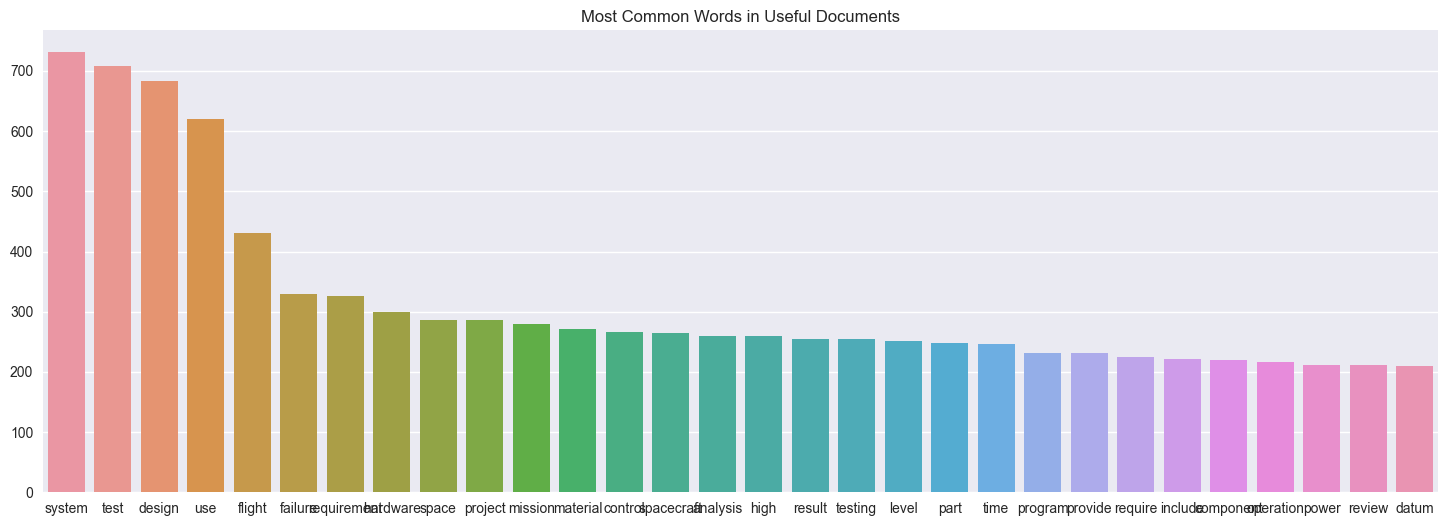

In [18]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x=use_common_words, y=use_common_counts)
plt.title('Most Common Words in Useful Documents')
plt.show()

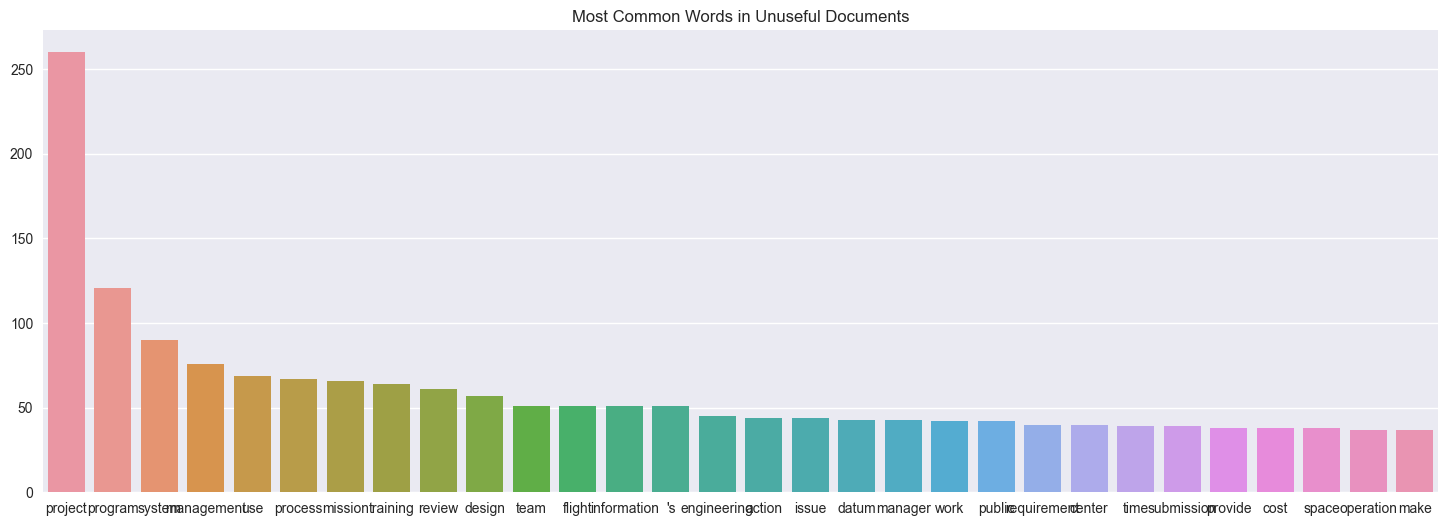

In [19]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x=not_use_common_words, y=not_use_common_counts)
plt.title('Most Common Words in Unuseful Documents')
plt.show()

# Machine Learning Model 2 for classification
A collection of models are hyper parameter tuned, then used for classifying each document as useable or not. The performance of the models are compared to determine which model is the best. First each model is tuned using the training and test set. Final performance is tested on a separate validation set. 

In [20]:
class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

def tokenizeText(sample):
    tokens = nlp(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    #print(tokens)
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    #print(tokens)
    return tokens


In [21]:
tfidf_vector = TfidfVectorizer(tokenizer=tokenizeText)

### Random Forest hyper parameter tuning

In [22]:
depths = np.arange(2,10,1)
n_estimators = np.arange(25,350,5)

In [23]:
train_acc = []
test_acc = []
conf_mat = []
for depth in depths:
    clf = RandomForestClassifier(n_estimators=100,max_depth=depth, random_state=0, class_weight="balanced_subsample")
    pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector),('clf',clf)])
    pipe.fit(X_train, y_train) #Training the model
    pred = pipe.predict(X_test)
    conf_mat.append(confusion_matrix(y_test,pred))
    train_acc.append(f1_score(y_train, pipe.predict(X_train), average='macro'))
    test_acc.append(f1_score(y_test, pred, average='macro'))

model_comparisons = pd.DataFrame({
    "depth": depths,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best depth value:", depths[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

best depth value: 2
train f1: 0.8771081859317154
test f1: 0.6825396825396826


In [24]:
train_acc = []
test_acc = []
conf_mat = []
for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=2, random_state=0,class_weight="balanced_subsample")
    pipe = Pipeline([('cleanText', CleanTextTransformer()),('vectorizer', tfidf_vector),('clf',clf)])
    pipe.fit(X_train, y_train) #Training the model
    pred = pipe.predict(X_test)
    conf_mat.append(confusion_matrix(y_test,pred))
    train_acc.append(f1_score(y_train, pipe.predict(X_train), average='macro'))
    test_acc.append(f1_score(y_test, pred, average='macro'))
    
model_comparisons = pd.DataFrame({
    "n estimators": n_estimators,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best n value:", n_estimators[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

best n value: 95
train f1: 0.8771081859317154
test f1: 0.7041685342895563


In [25]:
clf = RandomForestClassifier(n_estimators=85, max_depth=2, random_state=0, class_weight="balanced_subsample")
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector),('clf',clf)])
pipe.fit(X_train, y_train) #Training the model
print(confusion_matrix(y_test,pipe.predict(X_test)))
print(f1_score(y_train, pipe.predict(X_train), average='macro'))
print(f1_score(y_test, pipe.predict(X_test), average='macro'))

[[ 5  8]
 [ 4 43]]
0.8545343883140597
0.6660482374768089


In [26]:
RF_model = RandomForestClassifier(n_estimators=85, max_depth=2, random_state=0, class_weight="balanced_subsample")

### xgBoost hyper parameter tuning

In [27]:
depths = np.arange(2,10,1)
n_estimators = np.arange(25,300,5)

In [35]:
train_acc = []
test_acc = []
conf_mat = []
for depth in depths:
    clf = xgb.XGBClassifier(max_depth = depth, n_estimators = 200)
    pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector),('clf',clf)])
    pipe.fit(X_train, y_train.apply(lambda x: response_map[x])) #Training the model
    pred = pipe.predict(X_test)
    conf_mat.append(confusion_matrix(y_test.apply(lambda x: response_map[x]),pred))
    train_acc.append(f1_score(y_train.apply(lambda x: response_map[x]), pipe.predict(X_train), average='macro'))
    test_acc.append(f1_score(y_test.apply(lambda x: response_map[x]), pred, average='macro'))

model_comparisons = pd.DataFrame({
    "depth": depths,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best depth value:", depths[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("testf1:",  test_acc[np.argmax(test_acc)])

best depth value: 6
train f1: 1.0
testf1: 0.6248196248196248


In [36]:
train_acc = []
test_acc = []
conf_mat = []
for n in n_estimators:
    clf = xgb.XGBClassifier(max_depth = 7, n_estimators = n)
    pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector),('clf',clf)])
    pipe.fit(X_train, y_train.apply(lambda x: response_map[x])) #Training the model
    pred = pipe.predict(X_test)
    conf_mat.append(confusion_matrix(y_test.apply(lambda x: response_map[x]) , pred))
    train_acc.append(f1_score(y_train.apply(lambda x: response_map[x]), pipe.predict(X_train), average='macro'))
    test_acc.append(f1_score(y_test.apply(lambda x: response_map[x]), pred, average='macro'))


model_comparisons = pd.DataFrame({
    "n estimators": n_estimators,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best n value:", n_estimators[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

best n value: 30
train f1: 1.0
test f1: 0.5800000000000001


In [37]:
xgboost_model = xgb.XGBClassifier(max_depth = 7, n_estimators = 75)

### SVC hyper parameter tuning

In [38]:
kernals = ['linear', 'poly', 'rbf', 'sigmoid']
train_acc = []
test_acc = []
conf_mat = []
for kernal in kernals:
    clf = svm.SVC(class_weight="balanced", kernel=kernal)
    pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector),('clf',clf)])
    pipe.fit(X_train, y_train) #Training the model
    pred = pipe.predict(X_test)
    conf_mat.append(confusion_matrix(y_test, pred))
    train_acc.append(f1_score(y_train, pipe.predict(X_train), average='macro'))
    test_acc.append(f1_score(y_test, pred, average='macro'))

model_comparisons = pd.DataFrame({
    "kernels": kernals,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons

,kernels,train f1,test f1,confusion matrix
0,linear,0.986540,0.803601,"[[9, 4], [4, 43]]"
1,poly,1.000000,0.439252,"[[0, 13], [0, 47]]"
2,rbf,1.000000,0.639423,"[[3, 10], [0, 47]]"
3,sigmoid,0.979975,0.813665,"[[10, 3], [5, 42]]"


In [39]:
c_vals = np.arange(0.1, 3.1, 0.1)
train_acc = []
test_acc = []
conf_mat = []
for c in c_vals:
    clf = svm.SVC(kernel="linear", class_weight="balanced", C=c)
    pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector),('clf',clf)])
    pipe.fit(X_train, y_train) #Training the model
    pred = pipe.predict(X_test)
    conf_mat.append(confusion_matrix(y_test, pred))
    train_acc.append(f1_score(y_train, pipe.predict(X_train), average='macro'))
    test_acc.append(f1_score(y_test, pred, average='macro'))

model_comparisons = pd.DataFrame({
    "c values": c_vals,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})


print("best c value:", c_vals[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])
model_comparisons

best c value: 2.0
train f1: 1.0
test f1: 0.8437500000000001


,c values,train f1,test f1,confusion matrix
0,0.1,0.703474,0.514825,"[[1, 12], [0, 47]]"
1,0.2,0.960897,0.784946,"[[9, 4], [5, 42]]"
2,0.3,0.960897,0.813665,"[[10, 3], [5, 42]]"
3,0.4,0.973515,0.813665,"[[10, 3], [5, 42]]"
4,0.5,0.979975,0.813665,"[[10, 3], [5, 42]]"
5,0.6,0.979975,0.832736,"[[10, 3], [4, 43]]"
6,0.7,0.979975,0.832736,"[[10, 3], [4, 43]]"
7,0.8,0.979975,0.803601,"[[9, 4], [4, 43]]"
8,0.9,0.986540,0.803601,"[[9, 4], [4, 43]]"
9,1.0,0.986540,0.803601,"[[9, 4], [4, 43]]"


In [40]:
SVC_model = svm.SVC(kernel="linear", C=1.9, class_weight="balanced")

summary: the SVC model has the best performance with a linear kernel

## Model Comparison
### Single Fold validation

In [41]:
models = [SVC_model, xgboost_model, RF_model]
model_names = ["SVC", "XGBoost", "Random Forest"]

In [44]:
train_acc = []
test_acc = []
conf_mat = []
X = train_df['text']
y = train_df['use']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for m in models:
    model = m
    pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector), ('clf', model)])
    pipe.fit(X_train, y_train.apply(lambda x: response_map[x]))#Training the model
    pred = pipe.predict(X_test)
    train_pred = pipe.predict(X_train)
    conf_mat.append(confusion_matrix(y_test.apply(lambda x: response_map[x]),pred))
    train_acc.append(accuracy_score(y_train.apply(lambda x: response_map[x]), train_pred))
    test_acc.append(accuracy_score(y_test.apply(lambda x: response_map[x]),pred))

model_comparisons = pd.DataFrame({
    "model":model_names,
    "train accuracy": train_acc,
    "test accuracy": test_acc,
    "confusion matrix": conf_mat
})
display(model_comparisons)

,model,train accuracy,test accuracy,confusion matrix
0,SVC,0.995816,0.883333,"[[9, 4], [3, 44]]"
1,XGBoost,1.000000,0.766667,"[[2, 11], [3, 44]]"
2,Random Forest,0.899582,0.800000,"[[5, 8], [4, 43]]"


### K-fold cross validation

In [46]:
for m in models:
    model = m
    accuracies = []
    dfs = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    folds = []
    conf_matrices = []
    false_pos = []
    false_neg = []
    precision = []
    recall = []
    f1 = []
    j = 1

    for train_index, test_index in kf.split(train_df['text'],train_df['use']):
        X_train = train_df.iloc[train_index].loc[:, 'text']
        X_test = train_df.iloc[test_index].loc[:,'text']
        y_train = train_df.iloc[train_index].loc[:,'use']
        y_test = train_df.loc[test_index].loc[:,'use']

        #Train the model and analyze results
        pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector), ('clf', model)])
        pipe.fit(X_train, y_train.apply(lambda x: response_map[x])) #Training the model
        pred = pipe.predict(X_test)
        accuracies.append(accuracy_score(y_test.apply(lambda x: response_map[x]), pred))
        conf_matrices.append(confusion_matrix(y_test.apply(lambda x: response_map[x]), pred))
        folds.append(j)
        f1.append(f1_score(y_test.apply(lambda x: response_map[x]), pred, average="macro"))
        precision.append(precision_score(y_test.apply(lambda x: response_map[x]), pred,average="macro"))
        recall.append(recall_score(y_test.apply(lambda x: response_map[x]), pred, average="macro"))
    
        # how many occurances appear in the train set
        s_train = train_df.iloc[train_index].loc[:,'use'].value_counts()
        s_train.name = f"train {j}"
        s_test = train_df.iloc[test_index].loc[:,'use'].value_counts()
        s_test.name = f"test {j}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        j += 1
        
    results = pd.DataFrame({
        "fold":folds,
        "accuracy":accuracies,
        "recall score": recall,
        "precision score": precision,
        "f1 score": f1,
        "confusion matrix":conf_matrices,
    })
    display(results)

    recall_av = np.average(recall); acc_av= np.average(accuracies); f1_av= np.average(f1); prec_av = np.average(precision)
    av = pd.DataFrame({
        "average accuracy": [acc_av],
        "average f1": [f1_av],
        "average precision": [prec_av],
        "average recall": [recall_av]
    })

    display(av)

pd.concat(dfs,axis=1, sort=False)

,fold,accuracy,recall score,precision score,f1 score,confusion matrix
0,1,0.833333,0.615955,0.727273,0.639423,"[[3, 8], [2, 47]]"
1,2,0.866667,0.729167,0.817308,0.760000,"[[6, 6], [2, 46]]"
2,3,0.850000,0.687500,0.791105,0.718603,"[[5, 7], [2, 46]]"
3,4,0.866667,0.666667,0.928571,0.711538,"[[4, 8], [0, 48]]"
4,5,0.847458,0.696023,0.753676,0.717703,"[[5, 6], [3, 45]]"


,average accuracy,average f1,average precision,average recall
0,0.852825,0.709454,0.803587,0.679062


,fold,accuracy,recall score,precision score,f1 score,confusion matrix
0,1,0.833333,0.615955,0.727273,0.639423,"[[3, 8], [2, 47]]"
1,2,0.883333,0.770833,0.839869,0.797980,"[[7, 5], [2, 46]]"
2,3,0.883333,0.708333,0.936364,0.760137,"[[5, 7], [0, 48]]"
3,4,0.766667,0.572917,0.600962,0.580000,"[[3, 9], [5, 43]]"
4,5,0.762712,0.573864,0.586667,0.578571,"[[3, 8], [6, 42]]"


,average accuracy,average f1,average precision,average recall
0,0.825876,0.671222,0.738227,0.64838


,fold,accuracy,recall score,precision score,f1 score,confusion matrix
0,1,0.800000,0.666048,0.666048,0.666048,"[[5, 6], [6, 43]]"
1,2,0.833333,0.802083,0.747159,0.767081,"[[9, 3], [7, 41]]"
2,3,0.816667,0.666667,0.709150,0.682540,"[[5, 7], [4, 44]]"
3,4,0.783333,0.614583,0.643791,0.624820,"[[4, 8], [5, 43]]"
4,5,0.677966,0.591856,0.565718,0.565672,"[[5, 6], [13, 35]]"


,average accuracy,average f1,average precision,average recall
0,0.78226,0.661232,0.666373,0.668248


,train 1,test 1,|,train 2,test 2,|,train 3,test 3,|,train 4,test 4,|,train 5,test 5,|
use,192,49,|,193,48,|,193,48,|,193,48,|,193,48,|
not use,47,11,|,46,12,|,46,12,|,46,12,|,47,11,|


## Validation Set Comparison

In [47]:
train_acc = []; test_acc = []; train_recall = []; recall = []; false_pos = []; false_neg = []
precision = []; train_precision = []; train_f1 = []; f1 = []
conf_mat = []; pos = []; neg = []
for model in models:
    pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector),('clf',model)])
    pipe.fit(X,y.apply(lambda x: response_map[x]))
    predicted_usability = pipe.predict(X_valid)
    conf_mat.append(confusion_matrix(y_valid.apply(lambda x: response_map[x]), predicted_usability))
    train_acc.append((accuracy_score(pipe.predict(X), y.apply(lambda x: response_map[x]))))
    test_acc.append(accuracy_score(y_valid.apply(lambda x: response_map[x]), predicted_usability))
    #pos, neg = find_errors(validation_df_with_scores.loc[:,features], df_validation_target.astype(int), model,validation_df_with_scores)
    #false_pos.append(pos); false_neg.append(neg)
    train_f1.append(f1_score(y.apply(lambda x: response_map[x]), pipe.predict(X), average="macro"))
    f1.append(f1_score(y_valid.apply(lambda x: response_map[x]), predicted_usability, average="macro"))
    precision.append(precision_score(y_valid.apply(lambda x: response_map[x]), predicted_usability, average="macro"))
    train_precision.append(precision_score(y.apply(lambda x: response_map[x]), pipe.predict(X), average="macro"))
    recall.append(recall_score(y_valid.apply(lambda x: response_map[x]), predicted_usability, average="macro"))
    train_recall.append(recall_score(y.apply(lambda x: response_map[x]), pipe.predict(X), average="macro"))

print(len(model_names), len(models), len(train_acc))
results = pd.DataFrame({
    "model": model_names,
    "train accuracy": train_acc,
    "test accuracy":test_acc,
    "train recall": train_recall,
    "test recall score": recall,
    "test precision score": precision,
    "train precision":train_precision,
    "train f1 score": train_f1,
    "test f1 score": f1,
    "confusion matrix":conf_mat,
    #"false positives": false_pos,
    #"false negatives": false_neg
    })
display(results)

3 3 3


,model,train accuracy,test accuracy,train recall,test recall score,test precision score,train precision,train f1 score,test f1 score,confusion matrix
0,SVC,0.993311,0.929293,0.995851,0.821429,0.887931,0.983333,0.989442,0.849903,"[[10, 5], [2, 82]]"
1,XGBoost,1.000000,0.878788,1.000000,0.682143,0.783333,1.000000,1.000000,0.715517,"[[6, 9], [3, 81]]"
2,Random Forest,0.896321,0.848485,0.902955,0.801190,0.724026,0.824079,0.853239,0.750713,"[[11, 4], [11, 73]]"


## Class Imbalances

In [49]:
def over_sampled_model(train, test, y_train, y_test, model):
    clf = model
    #set up pipes
    over = SMOTE()
    steps = [('o', over)]
    tfidf_vector = TfidfVectorizer(tokenizer = tokenizeText)
    pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector)])
    sm_pipe = ibpipe(steps = steps)
    # data
    train1 = train.tolist()
    labelsTrain1 = y_train
    test1 = test.tolist()
    labelsTest1 = y_test
    #train
    vectorized = pipe.fit_transform(train1)
    train2, labelsTrain2 = sm_pipe.fit_resample(vectorized, labelsTrain1)
    clf.fit(train2, labelsTrain2)
    #test
    test1 = pipe.transform(test1)
    preds = clf.predict(test1)
    return preds, labelsTest1
    
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = tokenizeText)
over = SMOTE()
#under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over)]#, ('u', under)]
clf = svm.LinearSVC()
pipe1 = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector)])#, ('clf', clf)])
from imblearn.pipeline import Pipeline as ibpipe
smote_pipe = ibpipe(steps = steps)
# data
train1 = X_train
labelsTrain1 = y_train

test1 = X_test
labelsTest1 = y_test
# train
vectorized = pipe1.fit_transform(train1)
train2, labelsTrain2 = smote_pipe.fit_resample(vectorized, labelsTrain1)
clf.fit(train2, labelsTrain2)
# test
test1 = pipe1.transform(test1)
preds = clf.predict(test1)
preds2, labelsTest2 = over_sampled_model(X_train, X_test, y_train, y_test, clf)
print("accuracy:", accuracy_score(labelsTest1, preds), accuracy_score(labelsTest1, preds2))

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names_out()

for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

accuracy: 0.847457627118644 0.847457627118644


In [50]:
clf = svm.SVC()
#clf = RandomForestClassifier(n_estimators=225,max_depth=6, random_state=0)

pipe1 = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', tfidf_vector)])
over = SMOTE();steps = [('o', over)]
sm_pipe = ibpipe(steps = steps)
pipe2 = Pipeline([('clf',clf)])

# train
vectorized = pipe1.fit_transform(train_df['text'])
train, labelsTrain = sm_pipe.fit_resample(vectorized, train_df['use'])
pipe2.fit(train, labelsTrain)

"""
# test
preds = pipe.predict(test1)

conf_mat = confusion_matrix(df_validation_target.astype(int), predicted_usability)
train_acc = accuracy_score(labelsTrain1, pipe.predict(train1))
test_acc = accuracy_score(labelsTest1, preds)
#pos, neg = find_errors(test1, labelsTest1, pipe, train_df)
#false_pos = pos; false_neg = neg
train_f1 = f1_score(labelsTrain1, pipe.predict(train1), average="macro")
f1 = f1_score(labelsTest1, preds, average="macro")
precision = precision_score(labelsTest1, preds, average="macro")
train_precision = precision_score(labelsTrain1, pipe.predict(train1), average="macro")
recall = recall_score(labelsTest1, preds, average="macro")
train_recall = recall_score(labelsTrain1, pipe.predict(train1), average="macro")

results = pd.DataFrame({
        "train accuracy": [train_acc],
        "test accuracy":[test_acc],
        "train recall": [train_recall],
        "test recall score": [recall],
        "train precision":[train_precision],
        "test precision score": [precision],
        "train f1 score": [train_f1],
        "test f1 score": [f1],
        "confusion matrix":[conf_mat],
        "false positives": [false_pos],
        "false negatives": [false_neg]
    })
display(results)

print(metrics.classification_report(labelsTest1, preds, 
                                    target_names=["not use", "use"]))
                                    """

'\n# test\npreds = pipe.predict(test1)\n\nconf_mat = confusion_matrix(df_validation_target.astype(int), predicted_usability)\ntrain_acc = accuracy_score(labelsTrain1, pipe.predict(train1))\ntest_acc = accuracy_score(labelsTest1, preds)\n#pos, neg = find_errors(test1, labelsTest1, pipe, train_df)\n#false_pos = pos; false_neg = neg\ntrain_f1 = f1_score(labelsTrain1, pipe.predict(train1), average="macro")\nf1 = f1_score(labelsTest1, preds, average="macro")\nprecision = precision_score(labelsTest1, preds, average="macro")\ntrain_precision = precision_score(labelsTrain1, pipe.predict(train1), average="macro")\nrecall = recall_score(labelsTest1, preds, average="macro")\ntrain_recall = recall_score(labelsTrain1, pipe.predict(train1), average="macro")\n\nresults = pd.DataFrame({\n        "train accuracy": [train_acc],\n        "test accuracy":[test_acc],\n        "train recall": [train_recall],\n        "test recall score": [recall],\n        "train precision":[train_precision],\n        "test

In [51]:
preds = pipe2.predict(pipe1.transform(X_valid))


conf_mat = confusion_matrix(y_valid, preds)
train_acc = accuracy_score(labelsTrain, pipe2.predict(train))
test_acc = accuracy_score(y_valid, preds)
#pos, neg = find_errors(validation, labelsValidation, pipe, train_df)
#false_pos = pos; false_neg = neg
train_f1 = f1_score(labelsTrain, pipe2.predict(train), average="macro")
f1 = f1_score(y_valid, preds, average="macro")
precision = precision_score(y_valid, preds, average="macro")
train_precision = precision_score(labelsTrain, pipe2.predict(train), average="macro")
recall = recall_score(y_valid, preds, average="macro")
train_recall = recall_score(labelsTrain, pipe2.predict(train), average="macro")

results = pd.DataFrame({
        "train accuracy": [train_acc],
        "test accuracy":[test_acc],
        "train recall": [train_recall],
        "test recall score": [recall],
        "train precision":[train_precision],
        "test precision score": [precision],
        "train f1 score": [train_f1],
        "test f1 score": [f1],
        "confusion matrix":[conf_mat],
        "false positives": [false_pos],
        "false negatives": [false_neg]
    })
display(results)

#printNMostInformative(vectorizer, clf, 10)
print(metrics.classification_report(y_valid, preds, 
                                    target_names=["not use", "use"]))

,train accuracy,test accuracy,train recall,test recall score,train precision,test precision score,train f1 score,test f1 score,confusion matrix,false positives,false negatives
0,1.0,0.868687,1.0,0.594048,1.0,0.811842,1.0,0.621582,"[[3, 12], [1, 83]]",[],[]


              precision    recall  f1-score   support

     not use       0.75      0.20      0.32        15
         use       0.87      0.99      0.93        84

    accuracy                           0.87        99
   macro avg       0.81      0.59      0.62        99
weighted avg       0.85      0.87      0.83        99



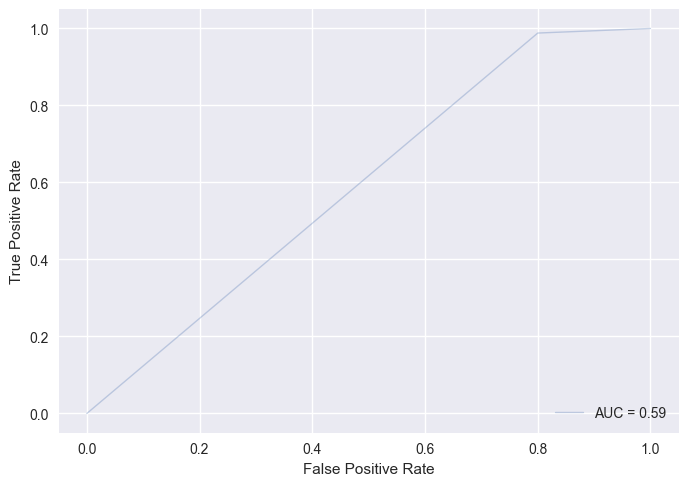

In [56]:
ax = plt.gca()
#model_disp = plot_roc_curve(pipe2, pipe1.transform(X_valid),y_valid, ax=ax, alpha=0.8)
fpr, tpr, thres = roc_curve(y_valid=="use",  pipe2.predict(pipe1.transform(X_valid)) == "use")
dis = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr))
dis.plot(alpha = 0.3, lw = 1, ax = ax)

encode_dict = {"use":0, "not use":1}
numlabelsValidation = [encode_dict[label] for label in y_valid]